In [1]:
import os
images = []
for dirs, subdirs, files in os.walk('Phoenix1'):
    images.append(files)

images[0][:5]

['20140911_1315.jpg',
 '20140325_1020.jpg',
 '20141103_1640.jpg',
 '20140613_1445.jpg',
 '20140322_1620.jpg']

In [2]:
flattened_images_list = [image for images_item in images for image in images_item]
flattened_images_list[:5]

['20140911_1315.jpg',
 '20140325_1020.jpg',
 '20141103_1640.jpg',
 '20140613_1445.jpg',
 '20140322_1620.jpg']

In [3]:
len(flattened_images_list)

4303

In [4]:
import pandas as pd 
df = pd.read_csv("pm2.csv")

In [5]:
df.head()

,date,pm2.5
0,20140101,73
1,20140102,86
2,20140103,59
3,20140104,83
4,20140105,79


In [6]:
from struct import unpack
import os


marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}


class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()
    
    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]            
            if len(data)==0:
                break        


bads = []
root_img = 'Phoenix1/'
for img in flattened_images_list:
    image = os.path.join(root_img,img)
    image = JPEG(image) 
    try:
        image.decode()   

    except:
        bads.append(img)

for name in bads:
    print(name)
    os.remove(os.path.join(root_img,name))

In [7]:
images = []
for dirs, subdirs, files in os.walk('Phoenix1'):
    images.append(files)

images[0][:5]

['20140911_1315.jpg',
 '20140325_1020.jpg',
 '20141103_1640.jpg',
 '20140613_1445.jpg',
 '20140322_1620.jpg']

In [8]:
flattened_images_list = [image for images_item in images for image in images_item]
flattened_images_list[:5]

['20140911_1315.jpg',
 '20140325_1020.jpg',
 '20141103_1640.jpg',
 '20140613_1445.jpg',
 '20140322_1620.jpg']

In [9]:
len(flattened_images_list)

4303

In [10]:
import shutil
def copyfile(filename,destination):
    shutil.copyfile(filename,destination)

for image in flattened_images_list:
    date = image[:8]
    index_val = df[df['date'] == int(date)].index.values[0]
    pm_val = df['pm2.5'][index_val]
    print(pm_val)
    if pm_val > 54:
        filename = 'Phoenix1/'+image
        destination = 'dataset/danger/'+image
        copyfile(filename,destination)
        continue
    elif pm_val < 30:
        filename = 'Phoenix1/'+image
        destination = 'dataset/healthy/'+image
        copyfile(filename,destination)
        continue
    else:
        filename = 'Phoenix1/'+image
        destination = 'dataset/moderate/'+image
        copyfile(filename,destination)


In [11]:
class_names = []
for dirs, subdirs,files in os.walk('dataset'):
    class_names.append(subdirs)
class_names = [item for sublist in class_names for item in sublist]
class_names

['healthy', 'danger', 'moderate']

In [12]:
for dir in os.listdir('dataset'):
    print(dir)
    print(len(os.listdir('dataset/'+dir)))

healthy
2232
danger
2232
moderate
2232


In [13]:
import tensorflow as tf 

In [14]:
import habana_frameworks.tensorflow as htf
htf.load_habana_module()

In [15]:
import ipyparallel as ipp
import os
os.environ["OMPI_ALLOW_RUN_AS_ROOT"] = "1"
os.environ["OMPI_ALLOW_RUN_AS_ROOT_CONFIRM"] = "1"

n_hpu=8
cluster = ipp.Cluster(engines='mpi', n=n_hpu)
client = cluster.start_and_connect_sync()

Starting 8 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/8 [00:00<?, ?engine/s]

In [16]:
%%px
import tensorflow as tf


In [17]:
%%px
batch_size = 16
img_height = 180
img_width = 180
data_dir = 'dataset/'

In [18]:
%%px
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'training',
    seed = 42,
    image_size = (img_height,img_width),
    batch_size=batch_size
)

[stdout:3] Found 6696 files belonging to 3 classes.
Using 5357 files for training.


[stdout:1] Found 6696 files belonging to 3 classes.
Using 5357 files for training.


[stderr:3] 2022-02-26 14:11:39.256955: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[stderr:1] 2022-02-26 14:11:39.257423: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[stdout:5] Found 6696 files belonging to 3 classes.
Using 5357 files for training.


[stdout:0] Found 6696 files belonging to 3 classes.
Using 5357 files for training.


[stdout:4] Found 6696 files belonging to 3 classes.
Using 5357 files for training.


[stderr:5] 2022-02-26 14:11:39.257884: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[stderr:0] 2022-02-26 14:11:39.257994: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[stderr:4] 2022-02-26 14:11:39.257577: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[stdout:6] Found 6696 files belonging to 3 classes.
Using 5357 files for training.


[stderr:6] 2022-02-26 14:11:39.258237: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[stdout:2] Found 6696 files belonging to 3 classes.
Using 5357 files for training.


[stderr:2] 2022-02-26 14:11:39.264815: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[stdout:7] Found 6696 files belonging to 3 classes.
Using 5357 files for training.


[stderr:7] 2022-02-26 14:11:39.270261: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
%%px
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'validation',
    seed = 42,
    image_size = (img_height,img_width),
    batch_size=batch_size
)

[stdout:4] Found 6696 files belonging to 3 classes.
Using 1339 files for validation.


[stdout:6] Found 6696 files belonging to 3 classes.
Using 1339 files for validation.


[stdout:5] Found 6696 files belonging to 3 classes.
Using 1339 files for validation.


[stdout:7] Found 6696 files belonging to 3 classes.
Using 1339 files for validation.


[stdout:2] Found 6696 files belonging to 3 classes.
Using 1339 files for validation.


[stdout:1] Found 6696 files belonging to 3 classes.
Using 1339 files for validation.


[stdout:3] Found 6696 files belonging to 3 classes.
Using 1339 files for validation.


[stdout:0] Found 6696 files belonging to 3 classes.
Using 1339 files for validation.


In [20]:
%%px
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
%%px
base_model = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=False, weights='imagenet',
)

In [22]:
%%px
base_model.trainable = False
for layer in base_model.layers[-100:]:
    layer.trainable = True

In [23]:
%%px
#create model

top = tf.keras.layers.Input(shape=(img_height,img_width,3))
x = base_model(top)
x = tf.keras.layers.GlobalMaxPooling2D()(x)
bottom = tf.keras.layers.Dense(3,activation='softmax')(x)

model_1 = tf.keras.Model(top,bottom)

In [24]:
%%px
model_1.summary()

[stdout:0] Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 4,053,414
Trainable params: 3,843
Non-trainable params: 4,049,571
_________________________________________________________________


[stdout:4] Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 4,053,414
Trainable params: 3,843
Non-trainable params: 4,049,571
_________________________________________________________________


[stdout:2] Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 4,053,414
Trainable params: 3,843
Non-trainable params: 4,049,571
_________________________________________________________________


[stdout:1] Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 4,053,414
Trainable params: 3,843
Non-trainable params: 4,049,571
_________________________________________________________________


[stdout:6] Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 4,053,414
Trainable params: 3,843
Non-trainable params: 4,049,571
_________________________________________________________________


[stdout:3] Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 4,053,414
Trainable params: 3,843
Non-trainable params: 4,049,571
_________________________________________________________________


[stdout:7] Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 4,053,414
Trainable params: 3,843
Non-trainable params: 4,049,571
_________________________________________________________________


[stdout:5] Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 4,053,414
Trainable params: 3,843
Non-trainable params: 4,049,571
_________________________________________________________________


In [25]:
%%px
#compile model

model_1.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [26]:
%%px

from mpi4py import MPI

BASE_TF_SERVER_PORT = 7850
SHUFFLE_BUFFER_SIZE = 10000

num_workers = MPI.COMM_WORLD.Get_size()
worker_index = MPI.COMM_WORLD.Get_rank()

def set_tf_config():
    """ Makes a TensorFlow cluster information and sets it to TF_CONFIG environment variable.
    """
    tf_config = {
        "cluster": {
            "worker": [f"localhost:{BASE_TF_SERVER_PORT + index}" for index in range(num_workers)]
        },
        "task": {"type": "worker", "index": worker_index}
    }
    tf_config_text = json.dumps(tf_config)
    os.environ["TF_CONFIG"] = tf_config_text
    print(f"TF_CONFIG = {tf_config_text}")
    return tf_config_text

In [27]:
%%px
early_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    verbose=0,
    mode="auto",
    restore_best_weights=True,
)

In [28]:
%%px

history_1 = model_1.fit(
    train_ds,
    validation_data = val_ds,
    epochs=200,
    callbacks=[early_callback]
)

[stdout:0] Epoch 1/200
335/335 [==============================] - 67s 189ms/step - loss: 1.5681 - accuracy: 0.5369 - val_loss: 1.0860 - val_accuracy: 0.5751
Epoch 2/200
335/335 [==============================] - 58s 173ms/step - loss: 1.1404 - accuracy: 0.6117 - val_loss: 0.8921 - val_accuracy: 0.6363
Epoch 3/200
335/335 [==============================] - ETA: 0s - loss: 0.9961 - accuracy: 0.6384

[stdout:2] Epoch 1/200
335/335 [==============================] - 67s 188ms/step - loss: 1.5552 - accuracy: 0.5298 - val_loss: 0.9963 - val_accuracy: 0.6482
Epoch 2/200
335/335 [==============================] - 58s 174ms/step - loss: 1.1275 - accuracy: 0.6037 - val_loss: 0.8775 - val_accuracy: 0.6796
Epoch 3/200
335/335 [==============================] - 52s 157ms/step - loss: 0.9917 - accuracy: 0.6405 - val_loss: 0.9584 - val_accuracy: 0.6393
Epoch 4/200
167/335 [=============>................] - ETA: 24s - loss: 0.9770 - accuracy: 0.6527

[stdout:1] Epoch 1/200
335/335 [==============================] - 68s 193ms/step - loss: 1.4924 - accuracy: 0.5550 - val_loss: 1.0058 - val_accuracy: 0.6169
Epoch 2/200
335/335 [==============================] - 59s 175ms/step - loss: 1.1480 - accuracy: 0.6168 - val_loss: 0.7864 - val_accuracy: 0.6945
Epoch 3/200
335/335 [==============================] - 58s 175ms/step - loss: 0.9852 - accuracy: 0.6429 - val_loss: 0.6996 - val_accuracy: 0.7207
Epoch 4/200
108/335 [========>.....................] - ETA: 33s - loss: 1.0411 - accuracy: 0.6435

[stdout:6] Epoch 1/200
335/335 [==============================] - 68s 192ms/step - loss: 1.5424 - accuracy: 0.5451 - val_loss: 0.9847 - val_accuracy: 0.6370
Epoch 2/200
335/335 [==============================] - 58s 173ms/step - loss: 1.1599 - accuracy: 0.6097 - val_loss: 0.7951 - val_accuracy: 0.6781
Epoch 3/200
335/335 [==============================] - 52s 156ms/step - loss: 1.0463 - accuracy: 0.6310 - val_loss: 0.7036 - val_accuracy: 0.7155
Epoch 4/200
158/335 [=============>................] - ETA: 25s - loss: 0.9780 - accuracy: 0.6562

[stdout:7] Epoch 1/200
335/335 [==============================] - 68s 193ms/step - loss: 1.5882 - accuracy: 0.5356 - val_loss: 0.9679 - val_accuracy: 0.6191
Epoch 2/200
335/335 [==============================] - 59s 176ms/step - loss: 1.1293 - accuracy: 0.6168 - val_loss: 0.8245 - val_accuracy: 0.7058
Epoch 3/200
335/335 [==============================] - 60s 179ms/step - loss: 1.0514 - accuracy: 0.6332 - val_loss: 0.7778 - val_accuracy: 0.6960
Epoch 4/200
101/335 [========>.....................] - ETA: 33s - loss: 0.9298 - accuracy: 0.6652

[stdout:4] Epoch 1/200
335/335 [==============================] - 68s 193ms/step - loss: 1.6062 - accuracy: 0.5371 - val_loss: 0.9427 - val_accuracy: 0.6565
Epoch 2/200
335/335 [==============================] - 59s 176ms/step - loss: 1.1672 - accuracy: 0.6091 - val_loss: 0.8726 - val_accuracy: 0.6617
Epoch 3/200
335/335 [==============================] - 54s 160ms/step - loss: 1.0732 - accuracy: 0.6330 - val_loss: 0.7011 - val_accuracy: 0.7162
Epoch 4/200
145/335 [===========>..................] - ETA: 27s - loss: 0.9448 - accuracy: 0.6629

[stdout:3] Epoch 1/200
335/335 [==============================] - 68s 192ms/step - loss: 1.4579 - accuracy: 0.5499 - val_loss: 0.9437 - val_accuracy: 0.6781
Epoch 2/200
335/335 [==============================] - 59s 177ms/step - loss: 1.1425 - accuracy: 0.6123 - val_loss: 0.7922 - val_accuracy: 0.6796
Epoch 3/200
335/335 [==============================] - 59s 176ms/step - loss: 1.0416 - accuracy: 0.6395 - val_loss: 0.6936 - val_accuracy: 0.7125
Epoch 4/200
106/335 [========>.....................] - ETA: 32s - loss: 0.9530 - accuracy: 0.6586

[stdout:5] Epoch 1/200
335/335 [==============================] - 69s 193ms/step - loss: 1.5506 - accuracy: 0.5511 - val_loss: 0.8980 - val_accuracy: 0.6557
Epoch 2/200
335/335 [==============================] - 60s 180ms/step - loss: 1.0769 - accuracy: 0.6199 - val_loss: 0.7825 - val_accuracy: 0.6863
Epoch 3/200
335/335 [==============================] - 59s 176ms/step - loss: 1.0540 - accuracy: 0.6323 - val_loss: 0.7353 - val_accuracy: 0.7125
Epoch 4/200
 97/335 [=======>......................] - ETA: 33s - loss: 0.9377 - accuracy: 0.6540

%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

In [ ]:
%%px
model_1.evaluate(val_ds)

[stdout:3] 12/84 [===>..........................] - ETA: 11s - loss: 2.2522 - accuracy: 0.2865

[stdout:5] 12/84 [===>..........................] - ETA: 11s - loss: 2.6089 - accuracy: 0.3802

[stdout:4] 12/84 [===>..........................] - ETA: 11s - loss: 2.7015 - accuracy: 0.3802

[stdout:6] 12/84 [===>..........................] - ETA: 11s - loss: 3.2444 - accuracy: 0.3177

[stdout:2] 12/84 [===>..........................] - ETA: 11s - loss: 1.8443 - accuracy: 0.5052

[stdout:1] 12/84 [===>..........................] - ETA: 11s - loss: 2.3262 - accuracy: 0.3698

[stdout:0] 12/84 [===>..........................] - ETA: 10s - loss: 1.9295 - accuracy: 0.3750

[stdout:7] 12/84 [===>..........................] - ETA: 10s - loss: 2.4070 - accuracy: 0.2917

%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

Received Keyboard Interrupt. Sending signal SIGINT to engines...


In [ ]:
%%px
import os
import json 
def train_mnist():
    set_tf_config()
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
    # Create and compile the distributed CNN model.
    model_1 = tf.keras.Model(top,bottom)
    model_1.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
        
    # Train the model.
    print("Calling model.fit()...")
    history_1 = model_1.fit(
    train_ds,
    validation_data = val_ds,
    epochs=200,
    callbacks=[early_callback]
)
    print("Calling model.evaluate()...")
    eval_results = model_1.evaluate(test_dataset, verbose=2)
    print(f"Evaluation results: {eval_results}")

In [ ]:
%%px
train_mnist()

[stdout:0] TF_CONFIG = {"cluster": {"worker": ["localhost:7850", "localhost:7851", "localhost:7852", "localhost:7853", "localhost:7854", "localhost:7855", "localhost:7856", "localhost:7857"]}, "task": {"type": "worker", "index": 0}}
Calling model.fit()...
Epoch 1/200
335/335 [==============================] - 67s 190ms/step - loss: 1.4776 - accuracy: 0.5473 - val_loss: 0.9097 - val_accuracy: 0.6199
Epoch 2/200
335/335 [==============================] - 58s 173ms/step - loss: 1.1543 - accuracy: 0.6162 - val_loss: 0.7947 - val_accuracy: 0.6632
Epoch 3/200
335/335 [==============================] - 59s 176ms/step - loss: 1.0129 - accuracy: 0.6448 - val_loss: 0.7090 - val_accuracy: 0.7020
Epoch 4/200
335/335 [==============================] - 57s 171ms/step - loss: 0.9379 - accuracy: 0.6470 - val_loss: 0.6459 - val_accuracy: 0.7170
Epoch 5/200
335/335 [==============================] - 51s 154ms/step - loss: 0.9251 - accuracy: 0.6629 - val_loss: 0.6411 - val_accuracy: 0.7214
Epoch 6/200
33

[stdout:3] TF_CONFIG = {"cluster": {"worker": ["localhost:7850", "localhost:7851", "localhost:7852", "localhost:7853", "localhost:7854", "localhost:7855", "localhost:7856", "localhost:7857"]}, "task": {"type": "worker", "index": 3}}
Calling model.fit()...
Epoch 1/200
335/335 [==============================] - 66s 187ms/step - loss: 1.4685 - accuracy: 0.5522 - val_loss: 0.9459 - val_accuracy: 0.6430
Epoch 2/200
335/335 [==============================] - 54s 160ms/step - loss: 1.1065 - accuracy: 0.6186 - val_loss: 0.7906 - val_accuracy: 0.6751
Epoch 3/200
335/335 [==============================] - 58s 173ms/step - loss: 1.0469 - accuracy: 0.6296 - val_loss: 0.7297 - val_accuracy: 0.7192
Epoch 4/200
335/335 [==============================] - 58s 174ms/step - loss: 0.9513 - accuracy: 0.6569 - val_loss: 0.7019 - val_accuracy: 0.7102
Epoch 5/200
335/335 [==============================] - 52s 156ms/step - loss: 0.9354 - accuracy: 0.6580 - val_loss: 0.6559 - val_accuracy: 0.7289
Epoch 6/200
33

[stdout:5] TF_CONFIG = {"cluster": {"worker": ["localhost:7850", "localhost:7851", "localhost:7852", "localhost:7853", "localhost:7854", "localhost:7855", "localhost:7856", "localhost:7857"]}, "task": {"type": "worker", "index": 5}}
Calling model.fit()...
Epoch 1/200
335/335 [==============================] - 69s 194ms/step - loss: 1.4517 - accuracy: 0.5540 - val_loss: 0.9593 - val_accuracy: 0.6385
Epoch 2/200
335/335 [==============================] - 54s 161ms/step - loss: 1.1575 - accuracy: 0.6164 - val_loss: 0.7983 - val_accuracy: 0.6796
Epoch 3/200
335/335 [==============================] - 60s 180ms/step - loss: 1.0218 - accuracy: 0.6339 - val_loss: 0.7174 - val_accuracy: 0.6856
Epoch 4/200
335/335 [==============================] - 58s 174ms/step - loss: 0.9766 - accuracy: 0.6448 - val_loss: 0.6926 - val_accuracy: 0.7028
Epoch 5/200
335/335 [==============================] - 52s 156ms/step - loss: 0.8855 - accuracy: 0.6584 - val_loss: 0.7282 - val_accuracy: 0.7140
Epoch 6/200
33

[stdout:7] TF_CONFIG = {"cluster": {"worker": ["localhost:7850", "localhost:7851", "localhost:7852", "localhost:7853", "localhost:7854", "localhost:7855", "localhost:7856", "localhost:7857"]}, "task": {"type": "worker", "index": 7}}
Calling model.fit()...
Epoch 1/200
335/335 [==============================] - 69s 194ms/step - loss: 1.5332 - accuracy: 0.5400 - val_loss: 1.0758 - val_accuracy: 0.5967
Epoch 2/200
335/335 [==============================] - 54s 162ms/step - loss: 1.1389 - accuracy: 0.6164 - val_loss: 0.8079 - val_accuracy: 0.6878
Epoch 3/200
335/335 [==============================] - 41s 122ms/step - loss: 1.0258 - accuracy: 0.6341 - val_loss: 0.7165 - val_accuracy: 0.6990
Epoch 4/200
335/335 [==============================] - 59s 177ms/step - loss: 1.0056 - accuracy: 0.6578 - val_loss: 0.6886 - val_accuracy: 0.7140
Epoch 5/200
335/335 [==============================] - 58s 175ms/step - loss: 0.8938 - accuracy: 0.6731 - val_loss: 0.6495 - val_accuracy: 0.7371
Epoch 6/200
33

[stdout:2] TF_CONFIG = {"cluster": {"worker": ["localhost:7850", "localhost:7851", "localhost:7852", "localhost:7853", "localhost:7854", "localhost:7855", "localhost:7856", "localhost:7857"]}, "task": {"type": "worker", "index": 2}}
Calling model.fit()...
Epoch 1/200
335/335 [==============================] - 67s 191ms/step - loss: 1.5430 - accuracy: 0.5466 - val_loss: 0.9674 - val_accuracy: 0.6341
Epoch 2/200
335/335 [==============================] - 59s 177ms/step - loss: 1.0973 - accuracy: 0.6205 - val_loss: 0.7671 - val_accuracy: 0.6684
Epoch 3/200
335/335 [==============================] - 59s 175ms/step - loss: 1.0231 - accuracy: 0.6345 - val_loss: 0.7591 - val_accuracy: 0.6953
Epoch 4/200
335/335 [==============================] - 59s 177ms/step - loss: 0.9402 - accuracy: 0.6550 - val_loss: 0.9521 - val_accuracy: 0.6296
Epoch 5/200
335/335 [==============================] - 45s 136ms/step - loss: 0.9375 - accuracy: 0.6601 - val_loss: 0.7902 - val_accuracy: 0.6833
Epoch 6/200
33

[stdout:6] TF_CONFIG = {"cluster": {"worker": ["localhost:7850", "localhost:7851", "localhost:7852", "localhost:7853", "localhost:7854", "localhost:7855", "localhost:7856", "localhost:7857"]}, "task": {"type": "worker", "index": 6}}
Calling model.fit()...
Epoch 1/200
335/335 [==============================] - 69s 194ms/step - loss: 1.6623 - accuracy: 0.5223 - val_loss: 0.9450 - val_accuracy: 0.6273
Epoch 2/200
335/335 [==============================] - 59s 175ms/step - loss: 1.1860 - accuracy: 0.6104 - val_loss: 0.8835 - val_accuracy: 0.6355
Epoch 3/200
335/335 [==============================] - 58s 174ms/step - loss: 1.0346 - accuracy: 0.6408 - val_loss: 0.8316 - val_accuracy: 0.6684
Epoch 4/200
335/335 [==============================] - 59s 177ms/step - loss: 0.9885 - accuracy: 0.6423 - val_loss: 0.7740 - val_accuracy: 0.6908
Epoch 5/200
335/335 [==============================] - 52s 154ms/step - loss: 0.9590 - accuracy: 0.6550 - val_loss: 0.7092 - val_accuracy: 0.7050
Epoch 6/200
33

[stdout:1] TF_CONFIG = {"cluster": {"worker": ["localhost:7850", "localhost:7851", "localhost:7852", "localhost:7853", "localhost:7854", "localhost:7855", "localhost:7856", "localhost:7857"]}, "task": {"type": "worker", "index": 1}}
Calling model.fit()...
Epoch 1/200
335/335 [==============================] - 68s 194ms/step - loss: 1.5573 - accuracy: 0.5440 - val_loss: 0.9721 - val_accuracy: 0.6087
Epoch 2/200
335/335 [==============================] - 50s 150ms/step - loss: 1.1190 - accuracy: 0.6177 - val_loss: 0.8019 - val_accuracy: 0.6721
Epoch 3/200
335/335 [==============================] - 49s 145ms/step - loss: 1.0296 - accuracy: 0.6341 - val_loss: 0.8338 - val_accuracy: 0.7072
Epoch 4/200
335/335 [==============================] - 58s 173ms/step - loss: 0.9577 - accuracy: 0.6556 - val_loss: 0.6853 - val_accuracy: 0.7222
Epoch 5/200
335/335 [==============================] - 54s 162ms/step - loss: 0.8989 - accuracy: 0.6642 - val_loss: 0.6683 - val_accuracy: 0.7274
Epoch 6/200
33

[stdout:4] TF_CONFIG = {"cluster": {"worker": ["localhost:7850", "localhost:7851", "localhost:7852", "localhost:7853", "localhost:7854", "localhost:7855", "localhost:7856", "localhost:7857"]}, "task": {"type": "worker", "index": 4}}
Calling model.fit()...
Epoch 1/200
335/335 [==============================] - 69s 195ms/step - loss: 1.5191 - accuracy: 0.5397 - val_loss: 0.9352 - val_accuracy: 0.6654
Epoch 2/200
335/335 [==============================] - 60s 178ms/step - loss: 1.0769 - accuracy: 0.6321 - val_loss: 0.7412 - val_accuracy: 0.7087
Epoch 3/200
335/335 [==============================] - 59s 176ms/step - loss: 0.9928 - accuracy: 0.6459 - val_loss: 0.6863 - val_accuracy: 0.7214
Epoch 4/200
335/335 [==============================] - 59s 176ms/step - loss: 0.9411 - accuracy: 0.6522 - val_loss: 0.6937 - val_accuracy: 0.7214
Epoch 5/200
335/335 [==============================] - 51s 152ms/step - loss: 0.8651 - accuracy: 0.6786 - val_loss: 0.6586 - val_accuracy: 0.7199
Epoch 6/200
33

%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

[7:execute]
---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
/tmp/ipykernel_95555/2235051485.py in <module>
----> 1 train_mnist()

/tmp/ipykernel_95555/1355923080.py in train_mnist()
     24 )
     25     print("Calling model.evaluate()...")
---> 26     eval_results = model.evaluate(test_dataset, verbose=2)
     27     print(f"Evaluation results: {eval_results}")

NameError: name 'model' is not defined
[0:execute]
---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
/tmp/ipykernel_95548/2235051485.py in <module>
----> 1 train_mnist()

/tmp/ipykernel_95548/1355923080.py in train_mnist()
     24 )
     25     print("Calling model.evaluate()...")
---> 26     eval_results = model.evaluate(test_dataset, verbose=2)
     27     print(f"Evaluation results: {eval_results}")

NameError: name 'mode

AlreadyDisplayedError: 8 errors

In [ ]:
%%px
eval_results = model_1.evaluate(val_ds, verbose=2)

%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

[stdout:5] 84/84 - 10s - loss: 0.5615 - accuracy: 0.7580 - 10s/epoch - 124ms/step


[stdout:6] 84/84 - 11s - loss: 0.5855 - accuracy: 0.7483 - 11s/epoch - 125ms/step


[stdout:1] 84/84 - 11s - loss: 0.5664 - accuracy: 0.7588 - 11s/epoch - 126ms/step


[stdout:2] 84/84 - 11s - loss: 0.6003 - accuracy: 0.7416 - 11s/epoch - 126ms/step


[stdout:4] 84/84 - 11s - loss: 0.5677 - accuracy: 0.7782 - 11s/epoch - 127ms/step


[stdout:0] 84/84 - 11s - loss: 0.5900 - accuracy: 0.7528 - 11s/epoch - 127ms/step


[stdout:7] 84/84 - 11s - loss: 0.6194 - accuracy: 0.7491 - 11s/epoch - 127ms/step


[stdout:3] 84/84 - 11s - loss: 0.5725 - accuracy: 0.7565 - 11s/epoch - 128ms/step


In [ ]:
%%px
model_1.save("model1")

%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

[stderr:1] 2022-02-26 13:58:24.428974: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/home/ubuntu/.local/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/ubuntu/.local/lib/python3.7/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


[stderr:3] 2022-02-26 13:58:24.426653: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/home/ubuntu/.local/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/ubuntu/.local/lib/python3.7/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


[stderr:6] 2022-02-26 13:58:24.431890: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/home/ubuntu/.local/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/ubuntu/.local/lib/python3.7/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


[stderr:5] 2022-02-26 13:58:24.502022: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/home/ubuntu/.local/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/ubuntu/.local/lib/python3.7/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


[stderr:0] 2022-02-26 13:58:24.530417: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/home/ubuntu/.local/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/ubuntu/.local/lib/python3.7/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


[stderr:4] 2022-02-26 13:58:24.545467: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/home/ubuntu/.local/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/ubuntu/.local/lib/python3.7/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


[stderr:7] 2022-02-26 13:58:24.546334: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/home/ubuntu/.local/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/ubuntu/.local/lib/python3.7/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


[stderr:2] 2022-02-26 13:58:24.547685: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/home/ubuntu/.local/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/ubuntu/.local/lib/python3.7/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


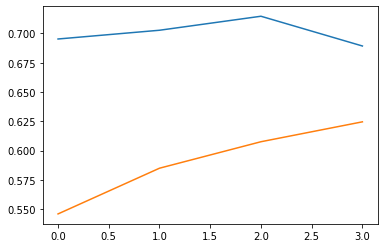

In [ ]:
%%px
import matplotlib.pyplot as plt

plt.plot(history_1.history['val_accuracy'])
plt.plot(history_1.history['accuracy'])

In [ ]:
client.shutdown(hub=True)

In [ ]:
import tensorflow as tf

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model('model1') #path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.

with open('model1.tflite', 'wb') as f:
  f.write(tflite_model)

2022-02-26 14:03:55.739893: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-26 14:04:04.981865: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:363] Ignored output_format.
2022-02-26 14:04:04.981905: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:366] Ignored drop_control_dependency.
2022-02-26 14:04:04.981910: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:372] Ignored change_concat_input_ranges.
2022-02-26 14:04:04.982695: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: model1
2022-02-26 14:04:05.071478: I tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2022-02-26 14:04:05.071508: I tensorflow/cc/saved_mo